## <span style="color:#ff5f27">🧬 Train Retrieval Model </span>


In [2]:
!pip install tensorflow==2.15 --quiet
!pip install tensorflow-recommenders==0.7.3 --quiet


## <span style="color:#ff5f27">📝 Imports </span>


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import StringLookup, Normalization
import tensorflow_recommenders as tfrs
import pandas as pd
import numpy as np
import hopsworks
import warnings
import re
warnings.filterwarnings('ignore')

2025-03-31 15:39:40.313685: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-31 15:39:40.321725: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-31 15:39:40.441357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-31 15:39:40.441458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-31 15:39:40.455544: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## <span style="color:#ff5f27">🔮 Connect to Hopsworks Feature Store </span>

In [2]:

# Connect to Hopsworks Feature Store
project = hopsworks.login()
fs = project.get_feature_store()



2025-03-31 15:39:48,700 INFO: Initializing external client
2025-03-31 15:39:48,702 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-31 15:39:50,161 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1220788


## <span style="color:#ff5f27">🔪 Feature Selection </span>


In [3]:

# Get feature groups
users_fg = fs.get_feature_group(
    name="users",
    version=1,
)

events_fg = fs.get_feature_group(
    name="events",
    version=1,
)

interactions_fg = fs.get_feature_group(
    name="interactions",
    version=1,
)



In [4]:
# Define features for query and candidate towers
# Define features for query and candidate towers
QUERY_FEATURES = ["user_id", "user_lat", "user_lon", "user_city", 
                  "user_weather_preference", "age", "user_interests"]

CANDIDATE_FEATURES = ["event_id", "title", "event_type", "event_lat", 
                      "event_lon", "event_city", "duration", "event_indoor_capability"]



In [5]:
print(users_fg.schema)
print(events_fg.schema)



[Feature('user_id', 'string', None, True, False, 'varchar(100)', None, 1422957), Feature('user_lat', 'double', None, False, False, 'double', None, 1422957), Feature('user_lon', 'double', None, False, False, 'double', None, 1422957), Feature('user_city', 'string', None, False, False, 'varchar(100)', None, 1422957), Feature('user_weather_preference', 'string', None, False, False, 'varchar(100)', None, 1422957), Feature('age', 'bigint', None, False, False, 'bigint', None, 1422957), Feature('user_interests', 'string', None, False, False, 'varchar(100)', None, 1422957), Feature('signup_date', 'timestamp', None, False, False, 'timestamp', None, 1422957), Feature('social_connectedness', 'bigint', None, False, False, 'bigint', None, 1422957)]
[Feature('event_id', 'string', None, True, False, 'varchar(100)', None, 1422958), Feature('title', 'string', None, False, False, 'varchar(100)', None, 1422958), Feature('event_type', 'string', None, False, False, 'varchar(100)', None, 1422958), Feature('e

In [6]:
# Select features for training data
selected_features = interactions_fg.select(["interaction_id"])\
    .join(users_fg.select(QUERY_FEATURES), on="user_id")\
    .join(events_fg.select(CANDIDATE_FEATURES), on="event_id")

In [7]:
selected_features.show(5)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (8.43s) 


,interaction_id,user_id,user_lat,user_lon,user_city,user_weather_preference,age,user_interests,event_id,title,event_type,event_lat,event_lon,event_city,duration,event_indoor_capability
0,4140ef03-afce-4fe5-a9a9-8e43fd45dfaa,LT819S,-33.842284,151.147230,Sydney,outdoor,26,sports literature cinema,OI841N,reengineered 3rdgeneration array food drink in...,Food & Drink,34.303070,140.184072,Tokyo,360,False
1,BI623H,UP287J,19.091580,72.883276,Mumbai,indoor,56,tech food travel,IO571I,balanced interactive artificial intelligence t...,Technology,18.986073,72.965255,Mumbai,480,True
2,08e342ae-f9b5-4358-9f41-cf89671b9ae2,RG723K,19.095005,72.785319,Mumbai,any,32,literature music,YW813D,visionary optimal monitoring education learnin...,Education & Learning,48.864336,2.384313,Paris,360,True
3,7cfbb86b-6d7a-4f1a-b05f-ffa78bc41ffb,DM205I,43.702871,-79.395358,Toronto,any,40,food sports cinema,RM794Y,reduced 6thgeneration complexity immersive exp...,Immersive Experiences,48.787962,2.362838,Paris,480,True
4,NQ623P,UE711E,19.081276,72.856138,Mumbai,outdoor,23,music art,UK320K,polarized uniform superstructure technology in...,Technology,19.122842,72.828077,Mumbai,360,True


## <span style="color:#ff5f27">⚙️ Feature View Creation </span>


In [ ]:
# Create feature view
feature_view = fs.create_feature_view(
    name='event_retrieval',
    version=1,
    query=selected_features,
)


In [24]:
# Create feature view
feature_view = fs.get_feature_view(
    name='event_retrieval',
    version=1
)

## <span style="color:#ff5f27">🏋️ Training Dataset </span>


In [25]:
# Split data into train, validation, and test sets
train_df, val_df, test_df, _, _, _ = feature_view.train_validation_test_split(
    validation_size=0.1, 
    test_size=0.01,
    description='Event retrieval dataset splits',
)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (9.13s) 


In [26]:

def df_to_ds(df):
    return tf.data.Dataset.from_tensor_slices({col: df[col] for col in df})

BATCH_SIZE = 2048
train_ds = df_to_ds(train_df).batch(BATCH_SIZE).cache().shuffle(BATCH_SIZE*10)
val_ds = df_to_ds(val_df).batch(BATCH_SIZE).cache()

# Extract unique values for categorical features
user_id_list = train_df["user_id"].unique().tolist()
city_list = train_df["user_city"].unique().tolist()
weather_pref_list = train_df["user_weather_preference"].unique().tolist()
event_id_list = train_df["event_id"].unique().tolist()
event_type_list = train_df["event_type"].unique().tolist()

print(f"Number of users: {len(user_id_list)}")
print(f"Number of events: {len(event_id_list)}")


Number of users: 24975
Number of events: 15396


In [32]:

#Define embedding dimension
EMB_DIM = 16

# Implement Query Tower (User Tower)
class QueryTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMB_DIM
        self.user_embedding = tf.keras.Sequential([
            StringLookup(vocabulary=user_id_list, mask_token=None),
            tf.keras.layers.Embedding(len(user_id_list) + 1, self.emb_dim)
        ])
        self.normalized_lat = Normalization(axis=None)
        self.normalized_lon = Normalization(axis=None)
        self.normalized_age = Normalization(axis=None)
        self.city_tokenizer = StringLookup(vocabulary=city_list, mask_token=None)
        self.weather_pref_tokenizer = StringLookup(vocabulary=weather_pref_list, mask_token=None)
        self.interests_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=5000, output_mode='int', output_sequence_length=10
        )
        self.interests_embedding = tf.keras.layers.Embedding(5000 + 1, self.emb_dim)
        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation="selu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation="selu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(self.emb_dim, kernel_regularizer=tf.keras.regularizers.l2(0.001))
        ])


    def call(self, inputs):
        user_emb = self.user_embedding(inputs["user_id"])
        lat = tf.reshape(self.normalized_lat(inputs["user_lat"]), (-1, 1))
        lon = tf.reshape(self.normalized_lon(inputs["user_lon"]), (-1, 1))
        city_embedding = tf.one_hot(self.city_tokenizer(inputs["user_city"]), len(city_list))
        weather_pref_embedding = tf.one_hot(self.weather_pref_tokenizer(inputs["user_weather_preference"]), len(weather_pref_list))
        age = tf.reshape(self.normalized_age(inputs["age"]), (-1, 1))
        interests_tokens = self.interests_vectorizer(inputs["user_interests"])
        interests_emb = self.interests_embedding(interests_tokens)
        interests_emb = tf.reduce_mean(interests_emb, axis=1)
        concatenated_inputs = tf.concat([
            user_emb, lat, lon, city_embedding, weather_pref_embedding, age, interests_emb
        ], axis=1)
        return self.fnn(concatenated_inputs)

# Implement Item Tower (Event Tower)
class ItemTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMB_DIM
        self.event_embedding = tf.keras.Sequential([
            StringLookup(vocabulary=event_id_list, mask_token=None),
            tf.keras.layers.Embedding(len(event_id_list) + 1, self.emb_dim)
        ])
        self.normalized_lat = Normalization(axis=None)
        self.normalized_lon = Normalization(axis=None)
        self.normalized_duration = Normalization(axis=None)
        self.city_tokenizer = StringLookup(vocabulary=city_list, mask_token=None)
        self.event_type_tokenizer = StringLookup(vocabulary=event_type_list, mask_token=None)
        self.title_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=5000, output_mode='int', output_sequence_length=10
        )
        self.title_embedding = tf.keras.layers.Embedding(5000 + 1, self.emb_dim)
        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation="selu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation="selu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(self.emb_dim, kernel_regularizer=tf.keras.regularizers.l2(0.001))
        ])


    def call(self, inputs):
        event_emb = self.event_embedding(inputs["event_id"])
        lat = tf.reshape(self.normalized_lat(inputs["event_lat"]), (-1, 1))
        lon = tf.reshape(self.normalized_lon(inputs["event_lon"]), (-1, 1))
        city_embedding = tf.one_hot(self.city_tokenizer(inputs["event_city"]), len(city_list))
        event_type_embedding = tf.one_hot(self.event_type_tokenizer(inputs["event_type"]), len(event_type_list))
        title_tokens = self.title_vectorizer(inputs["title"])
        title_emb = self.title_embedding(title_tokens)
        title_emb = tf.reduce_mean(title_emb, axis=1)
        duration = tf.reshape(self.normalized_duration(inputs["duration"]), (-1, 1))
        indoor_capability = tf.cast(inputs["event_indoor_capability"], tf.float32)
        indoor_capability = tf.reshape(indoor_capability, (-1, 1))
        concatenated_inputs = tf.concat([
            event_emb, lat, lon, city_embedding, event_type_embedding, title_emb, duration, indoor_capability
        ], axis=1)
        return self.fnn(concatenated_inputs)

# Implement Two-Tower Model
class TwoTowerModel(tf.keras.Model):
    def __init__(self, query_model, item_model):
        super().__init__()
        self.query_model = query_model
        self.item_model = item_model
        event_df = train_df[CANDIDATE_FEATURES]
        event_df.drop_duplicates(subset="event_id", inplace=True)
        event_ds = df_to_ds(event_df).batch(BATCH_SIZE)
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=event_ds.map(self.item_model)
            )
        )

    def train_step(self, batch):
        with tf.GradientTape() as tape:
            user_embeddings = self.query_model(batch)
            event_embeddings = self.item_model(batch)
            loss = self.task(
                user_embeddings, 
                event_embeddings,
                compute_metrics=False,
            )
            regularization_loss = sum(self.losses)
            total_loss = loss + regularization_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        metrics = {
            "loss": loss,
            "regularization_loss": regularization_loss,
            "total_loss": total_loss
        }
        return metrics

    def test_step(self, batch):
        user_embeddings = self.query_model(batch)
        event_embeddings = self.item_model(batch)

        loss = self.task(
            user_embeddings, 
            event_embeddings,
            compute_metrics=True,
        )
        regularization_loss = sum(self.losses)
        total_loss = loss + regularization_loss

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss
        return metrics


In [33]:
# Initialize models
query_model = QueryTower()
item_model = ItemTower()

# Adapt normalization layers with training data
query_model.normalized_lat.adapt(train_ds.map(lambda x: x["user_lat"]))
query_model.normalized_lon.adapt(train_ds.map(lambda x: x["user_lon"]))
query_model.normalized_age.adapt(train_ds.map(lambda x: x["age"]))
item_model.normalized_lat.adapt(train_ds.map(lambda x: x["event_lat"]))
item_model.normalized_lon.adapt(train_ds.map(lambda x: x["event_lon"]))
item_model.normalized_duration.adapt(train_ds.map(lambda x: x["duration"]))

# Adapt text vectorization layers
query_model.interests_vectorizer.adapt(train_ds.map(lambda x: x["user_interests"]))
item_model.title_vectorizer.adapt(train_ds.map(lambda x: x["title"]))


item_df = train_df[CANDIDATE_FEATURES]
item_df.drop_duplicates(subset="event_id", inplace=True)
item_ds = df_to_ds(item_df)

item_model(next(iter(item_ds.batch(1))))

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[ 0.8377559 ,  0.40929157,  1.1438503 , -0.19603978,  0.2155392 ,
        -0.19687073,  0.16677111,  0.4534817 ,  0.5245908 ,  0.15011582,
        -0.71581954,  0.26453426,  0.1371074 ,  0.13845433, -0.8279205 ,
         0.3847481 ]], dtype=float32)>

Epoch 1/50
73/73 [==============================] - 12s 135ms/step - loss: 16427.0842 - regularization_loss: 0.0482 - total_loss: 16427.1323 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 5.4289e-04 - val_factorized_top_k/top_10_categorical_accuracy: 0.0014 - val_factorized_top_k/top_50_categorical_accuracy: 0.0072 - val_factorized_top_k/top_100_categorical_accuracy: 0.0144 - val_loss: 937.4453 - val_regularization_loss: 0.0462 - val_total_loss: 937.4914
Epoch 2/50
73/73 [==============================] - 10s 143ms/step - loss: 14281.6896 - regularization_loss: 0.0456 - total_loss: 14281.7351 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0012 - val_factorized_top_k/top_10_categorical_accuracy: 0.0016 - val_factorized_top_k/top_50_categorical_accuracy: 0.0068 - val_factorized_top_k/top_100_categorical_accuracy: 0.0141 - val_loss: 933.1647 - val_regulariz

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

model = TwoTowerModel(query_model, item_model)
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.01, weight_decay=0.01)
model.compile(optimizer=optimizer)# Add this after model compilation and before training


# Define early stopping callback
early_stop = EarlyStopping(
    monitor="val_factorized_top_k/top_10_categorical_accuracy",
    mode="max",
    patience=10,
    restore_best_weights=True
)

# Train with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop]
)




# Evaluate final performance
eval_results = model.evaluate(
    val_ds,
    return_dict=True
)
print("\nFinal Evaluation Metrics:")
for metric, value in eval_results.items():
    print(f"{metric}: {value:.4f}")

Epoch 1/50
73/73 [==============================] - 17s 178ms/step - loss: 10251.6336 - regularization_loss: 0.0522 - total_loss: 10251.6857 - val_factorized_top_k/top_1_categorical_accuracy: 6.0321e-04 - val_factorized_top_k/top_5_categorical_accuracy: 0.0029 - val_factorized_top_k/top_10_categorical_accuracy: 0.0063 - val_factorized_top_k/top_50_categorical_accuracy: 0.0475 - val_factorized_top_k/top_100_categorical_accuracy: 0.1057 - val_loss: 1707.3545 - val_regularization_loss: 0.0526 - val_total_loss: 1707.4071
Epoch 2/50
73/73 [==============================] - 11s 146ms/step - loss: 9695.2153 - regularization_loss: 0.0544 - total_loss: 9695.2696 - val_factorized_top_k/top_1_categorical_accuracy: 6.0321e-04 - val_factorized_top_k/top_5_categorical_accuracy: 0.0039 - val_factorized_top_k/top_10_categorical_accuracy: 0.0097 - val_factorized_top_k/top_50_categorical_accuracy: 0.0618 - val_factorized_top_k/top_100_categorical_accuracy: 0.1337 - val_loss: 1814.5056 - val_regularizati

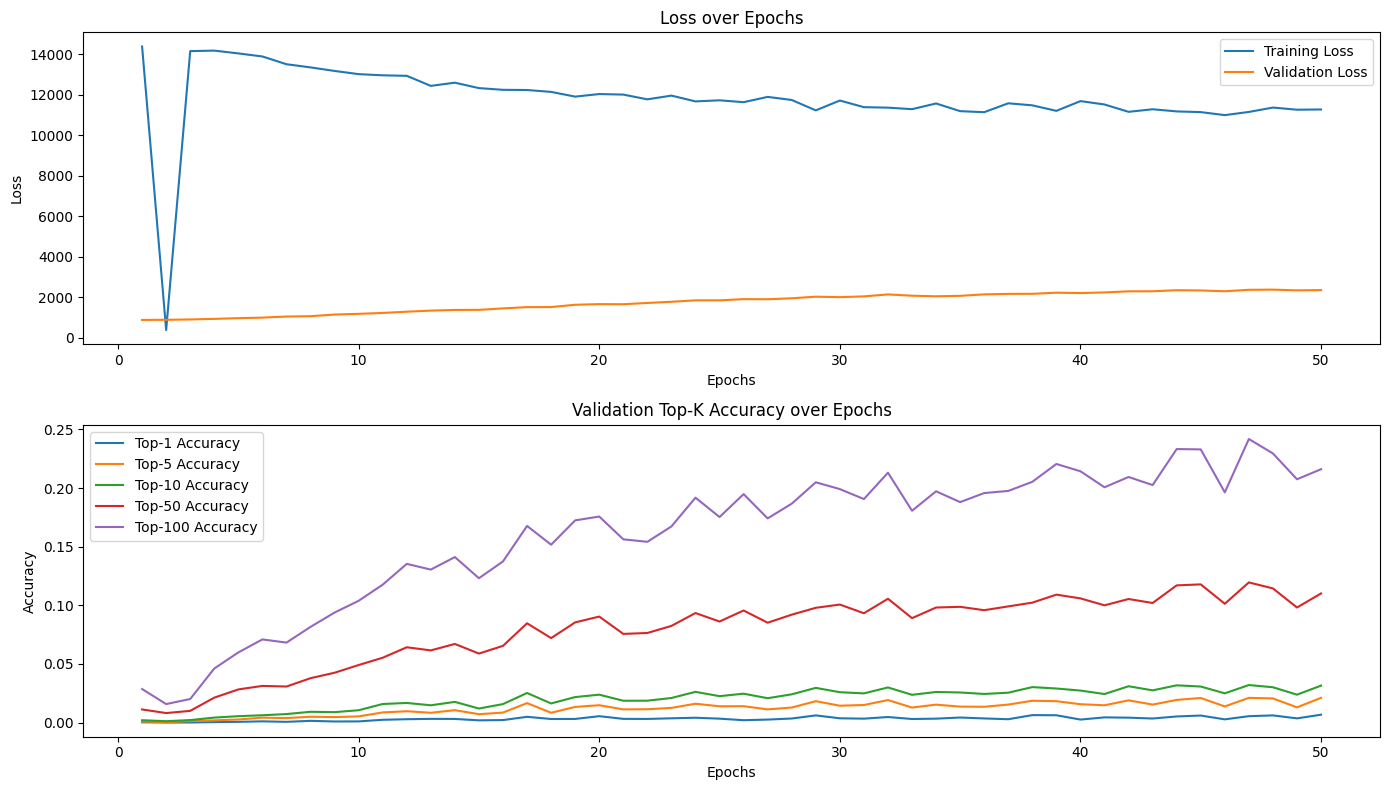

In [15]:
import matplotlib.pyplot as plt


# Plotting function
def plot_metrics(history):
    epochs = range(1, len(history["loss"]) + 1)

    plt.figure(figsize=(14, 8))

    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, history["loss"], label="Training Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Top-K Accuracies
    plt.subplot(2, 1, 2)
    for k in [1, 5, 10, 50, 100]:
        metric = f"val_factorized_top_k/top_{k}_categorical_accuracy"
        plt.plot(epochs, history[metric], label=f"Top-{k} Accuracy")

    plt.title("Validation Top-K Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function to plot
#plot_metrics(history)
plot_metrics(history.history)


---

In [ ]:
# Save models
mr = project.get_model_registry()

tf.saved_model.save(model.query_model, "query_model")
tf.saved_model.save(model.item_model, "candidate_model")

# Create schemas for models
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

query_model_input_schema = Schema(train_df[QUERY_FEATURES])
query_model_output_schema = Schema([{
    "name": "query_embedding",
    "type": "float32",
    "shape": [EMB_DIM],
}])

query_model_schema = ModelSchema(
    input_schema=query_model_input_schema,
    output_schema=query_model_output_schema,
)

mr_query_model = mr.tensorflow.create_model(
    name="query_model",
    description="Model that generates query embeddings from user features for event recommendation",
    input_example=train_df[QUERY_FEATURES].sample().to_dict("records"),
    model_schema=query_model_schema,
)

mr_query_model.save("query_model")

candidate_model_input_schema = Schema(train_df[CANDIDATE_FEATURES])
candidate_model_output_schema = Schema([{
    "name": "candidate_embedding",
    "type": "float32",
    "shape": [EMB_DIM],
}])

candidate_model_schema = ModelSchema(
    input_schema=candidate_model_input_schema,
    output_schema=candidate_model_output_schema,
)

mr_candidate_model = mr.tensorflow.create_model(
    name="candidate_model",
    description="Model that generates candidate embeddings from event features for event recommendation",
    input_example=train_df[CANDIDATE_FEATURES].sample().to_dict("records"),
    model_schema=candidate_model_schema,
)

mr_candidate_model.save("candidate_model")

print("Models successfully trained and saved to the Model Registry")
